In [134]:
import sys

import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import h5py

!pip install torchinfo
from torchinfo import summary

from google.colab import drive
drive.mount('/content/drive')

base = '/content/drive/MyDrive/a3net'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
f_data = h5py.File(f'{base}/sdss_galaxy_spec.hdf5', 'r')

# Fiber identification
plateid = f_data['raw']['plateid'][()]
fiberid = f_data['raw']['fiberid'][()]
mjd = f_data['raw']['mjd'][()]

# Position
#ra = f_data['raw']['ra'][()]
#dec = f_data['raw']['dec'][()]
z = f_data['raw']['z'][()]
#zerr = f_data['raw']['zerr'][()]

# Physical properties
age = f_data['raw']['age'][()]
metallicity = f_data['raw']['metallicity'][()]
smass = f_data['raw']['smass'][()]

# Spectra
wavelength = f_data['raw']['wavelength'][()]
specs = f_data['raw']['spec'][()]
specerrs = f_data['raw']['specerr'][()]

mask = np.where((z>0) & (metallicity>0) & (age>0) & (smass>0))
specs = specs[mask]
z = z[mask]
metallicity = metallicity[mask]
age = age[mask]
smass = smass[mask]

shape = specs.shape

# Reduce spectral bins to reduce computational cost
res = 30
nbins = shape[1] // res
specs_low_res = specs[:,:nbins * res].reshape(shape[0], nbins, res).mean(axis=2)
wavelength_low_res = wavelength[:nbins * res].reshape(nbins, res).mean(axis=1)

# normalization
normalized_data = specs_low_res - np.min(specs_low_res) + 1
normalized_data = np.log10( normalized_data )
min_val, max_val = np.min(normalized_data), np.max(normalized_data)
normalized_data = (normalized_data - min_val) / (max_val - min_val)

# divide into training / validation / test data
ndata = len(specs_low_res)
ndata_train = int(ndata*0.8)
ndata_val = int(ndata - ndata_train)

training_data = normalized_data[:ndata_train-ndata_val]
val_data = normalized_data[ndata_train-ndata_val:ndata_train]
test_data = normalized_data[ndata_train:]

# convert to torch tensor
training_data = torch.from_numpy(training_data.astype(np.float32))
val_data = torch.from_numpy(val_data.astype(np.float32)).to(device)
test_data = torch.from_numpy(test_data.astype(np.float32)).to(device)

# labels for test data visualization
z_test = z[ndata_train:]
age_test = age[ndata_train:]
metallicity_test = metallicity[ndata_train:]
smass_test = smass[ndata_train:]


print("training data size: ", training_data.size())
print("validation data size: ", val_data.size())
print("test data size: ", test_data.size())

training data size:  torch.Size([5943, 151])
validation data size:  torch.Size([1981, 151])
test data size:  torch.Size([1981, 151])


In [136]:
from sklearn.preprocessing import MinMaxScaler

# Combine the conditional properties
conditional_data = np.stack([z, np.log10(age), np.log10(metallicity), np.log10(smass)], axis=1)

# Split the conditional data based on the existing splits
training_conditional_data = conditional_data[:ndata_train-ndata_val]
val_conditional_data = conditional_data[ndata_train-ndata_val:ndata_train]
test_conditional_data = conditional_data[ndata_train:]

# Scale the conditional data using MinMaxScaler
scaler = MinMaxScaler()
training_conditional_data_scaled = scaler.fit_transform(training_conditional_data)
val_conditional_data_scaled = scaler.transform(val_conditional_data)
test_conditional_data_scaled = scaler.transform(test_conditional_data)

# Convert to PyTorch tensors and move to device
training_conditional_data_scaled = torch.from_numpy(training_conditional_data_scaled.astype(np.float32))
val_conditional_data_scaled = torch.from_numpy(val_conditional_data_scaled.astype(np.float32)).to(device)
test_conditional_data_scaled = torch.from_numpy(test_conditional_data_scaled.astype(np.float32)).to(device)

print("training conditional data size: ", training_conditional_data_scaled.size())
print("validation conditional data size: ", val_conditional_data_scaled.size())
print("test conditional data size: ", test_conditional_data_scaled.size())

training conditional data size:  torch.Size([5943, 4])
validation conditional data size:  torch.Size([1981, 4])
test conditional data size:  torch.Size([1981, 4])


In [137]:
### CVAE model ###
class VAE_Encoder(nn.Module):
  def __init__(self, input_dim, conditional_dim, hidden_dim, latent_dim):
    super().__init__()

    self.blocks = nn.ModuleList()

    self.blocks.append(nn.Sequential(
        nn.Linear(input_dim + conditional_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.LeakyReLU()
    ))

    self.blocks.append(nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.LeakyReLU()
    ))

    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

  def forward(self, x, c):
    x_c = torch.cat([x, c], dim=1)
    for blk in self.blocks:
      x_c = blk(x_c)

    mu = self.fc_mu(x_c)
    logvar = self.fc_logvar(x_c)
    return mu, logvar

class VAE_Decoder(nn.Module):
  def __init__(self, input_dim, conditional_dim, hidden_dim, latent_dim):
    super().__init__()

    self.blocks = nn.ModuleList()

    self.blocks.append(nn.Sequential(
        nn.Linear(latent_dim + conditional_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.LeakyReLU()
    ))

    self.blocks.append(nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.LeakyReLU()
    ))

    self.conv_final = nn.Linear(hidden_dim, input_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, z, c):
    z_c = torch.cat([z, c], dim=1)
    for blk in self.blocks:
      z_c = blk(z_c)

    x = self.sigmoid(self.conv_final(z_c))
    return x

class VAE(nn.Module):
  def __init__(self, input_dim, conditional_dim, hidden_dim, latent_dim):
    super().__init__()
    self.encoder = VAE_Encoder(input_dim, conditional_dim, hidden_dim, latent_dim)
    self.decoder = VAE_Decoder(input_dim, conditional_dim, hidden_dim, latent_dim)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x, c):
    mu, logvar = self.encoder(x, c)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z, c), mu, logvar

  def generate_sample(self, z, c):
    return self.decoder(z, c)

# Define necessary variables
latent_dim = 2
conditional_dim = 4 # redshift, age, metallicity, stellar mass
input_dim = specs_low_res.shape[-1]
batch_size = 32


### define model
cvae = VAE(
    input_dim = input_dim,
    conditional_dim = conditional_dim,
    hidden_dim = 512,
    latent_dim = latent_dim
    )

cvae.to(device)

# Print encoder summary
summary(cvae.encoder, input_size=[(batch_size, input_dim), (batch_size, conditional_dim)], col_names=["input_size", "output_size", "num_params"])

# Print decoder summary
summary(cvae.decoder, input_size=[(batch_size, latent_dim), (batch_size, conditional_dim)], col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE_Decoder                              [32, 2]                   [32, 151]                 --
├─ModuleList: 1-1                        --                        --                        --
│    └─Sequential: 2-1                   [32, 6]                   [32, 512]                 --
│    │    └─Linear: 3-1                  [32, 6]                   [32, 512]                 3,584
│    │    └─BatchNorm1d: 3-2             [32, 512]                 [32, 512]                 1,024
│    │    └─LeakyReLU: 3-3               [32, 512]                 [32, 512]                 --
│    └─Sequential: 2-2                   [32, 512]                 [32, 512]                 --
│    │    └─Linear: 3-4                  [32, 512]                 [32, 512]                 262,656
│    │    └─BatchNorm1d: 3-5             [32, 512]                 [32, 512]                 1,024
│    │    └─LeakyReLU

In [138]:
def cvae_loss_function(recon_x, x, mu, logvar):
  """
  Calculates the loss for the Conditional Variational Autoencoder (CVAE).

  Args:
    recon_x: Reconstructed input data.
    x: Original input data.
    mu: Mean of the latent space distribution.
    logvar: Log variance of the latent space distribution.

  Returns:
    The total loss, which is the sum of the Binary Cross-Entropy (BCE) loss
    and the Kullback-Leibler (KL) divergence loss.
  """
  bce_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return bce_loss + kl_loss

Epoch 0, Loss: 104.68709564208984, Loss(val): 104.48432159423828
Epoch 1, Loss: 104.36759185791016, Loss(val): 104.33251953125
Epoch 2, Loss: 104.06277465820312, Loss(val): 104.39501190185547
Epoch 3, Loss: 104.40660095214844, Loss(val): 104.24252319335938
Epoch 4, Loss: 104.0025634765625, Loss(val): 104.20509338378906
Epoch 5, Loss: 104.36357879638672, Loss(val): 104.20841979980469
Epoch 6, Loss: 104.412353515625, Loss(val): 104.14306640625
Epoch 7, Loss: 104.11514282226562, Loss(val): 104.1658706665039
Epoch 8, Loss: 103.70950317382812, Loss(val): 104.14244079589844
Epoch 9, Loss: 104.21378326416016, Loss(val): 104.16645050048828
Epoch 10, Loss: 104.06494903564453, Loss(val): 104.13220977783203
Epoch 11, Loss: 104.16445922851562, Loss(val): 104.12832641601562
Epoch 12, Loss: 104.1700210571289, Loss(val): 104.11441802978516
Epoch 13, Loss: 103.80242919921875, Loss(val): 104.12613677978516
Epoch 14, Loss: 104.36627960205078, Loss(val): 104.13118743896484
Epoch 15, Loss: 104.55961608886

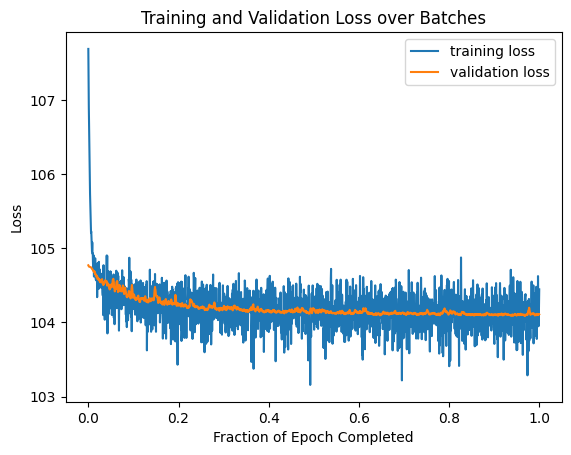

In [139]:
# Define the Adam optimizer for the CVAE model parameters
learning_rate = 1e-4
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)

# Set the number of epochs and batch size
num_epochs = 20
batch_size = 64

# Calculate the number of batches
num_batches = (ndata_train - ndata_val) // batch_size

# Initialize a dictionary to store the training and validation loss
history = {"loss": [], "loss_val": []}

# Start the training loop
for epoch in range(num_epochs):
  # Shuffle the indices of the training data and apply to conditional data
  indices = torch.randperm(ndata_train - ndata_val)
  training_data_shuffled = training_data[indices]
  training_conditional_data_scaled_shuffled = training_conditional_data_scaled[indices]

  for i in range(num_batches):
    # Set the model to training mode
    cvae.train()
    # Zero the optimizer's gradients
    optimizer.zero_grad()

    # Select the current batch of training data and conditional data
    x_train = training_data_shuffled[batch_size * i : batch_size * (i+1)].to(device)
    c_train = training_conditional_data_scaled_shuffled[batch_size * i : batch_size * (i+1)].to(device)

    # Pass the training data and conditional data batch through the CVAE model
    recon_batch, mu, logvar = cvae(x_train, c_train)

    # Calculate the loss for the current training batch
    loss = cvae_loss_function(recon_batch, x_train, mu, logvar) / batch_size

    # Perform backpropagation and update the model parameters
    loss.backward()
    optimizer.step()

    # Set the model to evaluation mode
    cvae.eval()
    with torch.no_grad():
      # Calculate the loss for the validation data and conditional data
      recon_batch_val, mu_val, logvar_val = cvae(val_data, val_conditional_data_scaled)
      loss_val = cvae_loss_function(recon_batch_val, val_data, mu_val, logvar_val) / len(val_data)

    # Append the training loss and validation loss for the current batch
    history["loss"].append(loss.item())
    history["loss_val"].append(loss_val.item())

  # Print the epoch number, the last training loss, and the last validation loss
  print(f"Epoch {epoch}, Loss: {loss.item()}, Loss(val): {loss_val.item()}")

# Create a new figure and plot the training and validation loss
plt.figure()
x = np.linspace(0, 1, len(history["loss"]))
plt.plot(x, history["loss"], label="training loss")
plt.plot(x, history["loss_val"], label="validation loss")
plt.legend()
plt.xlabel("Fraction of Epoch Completed")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Batches")
plt.show()

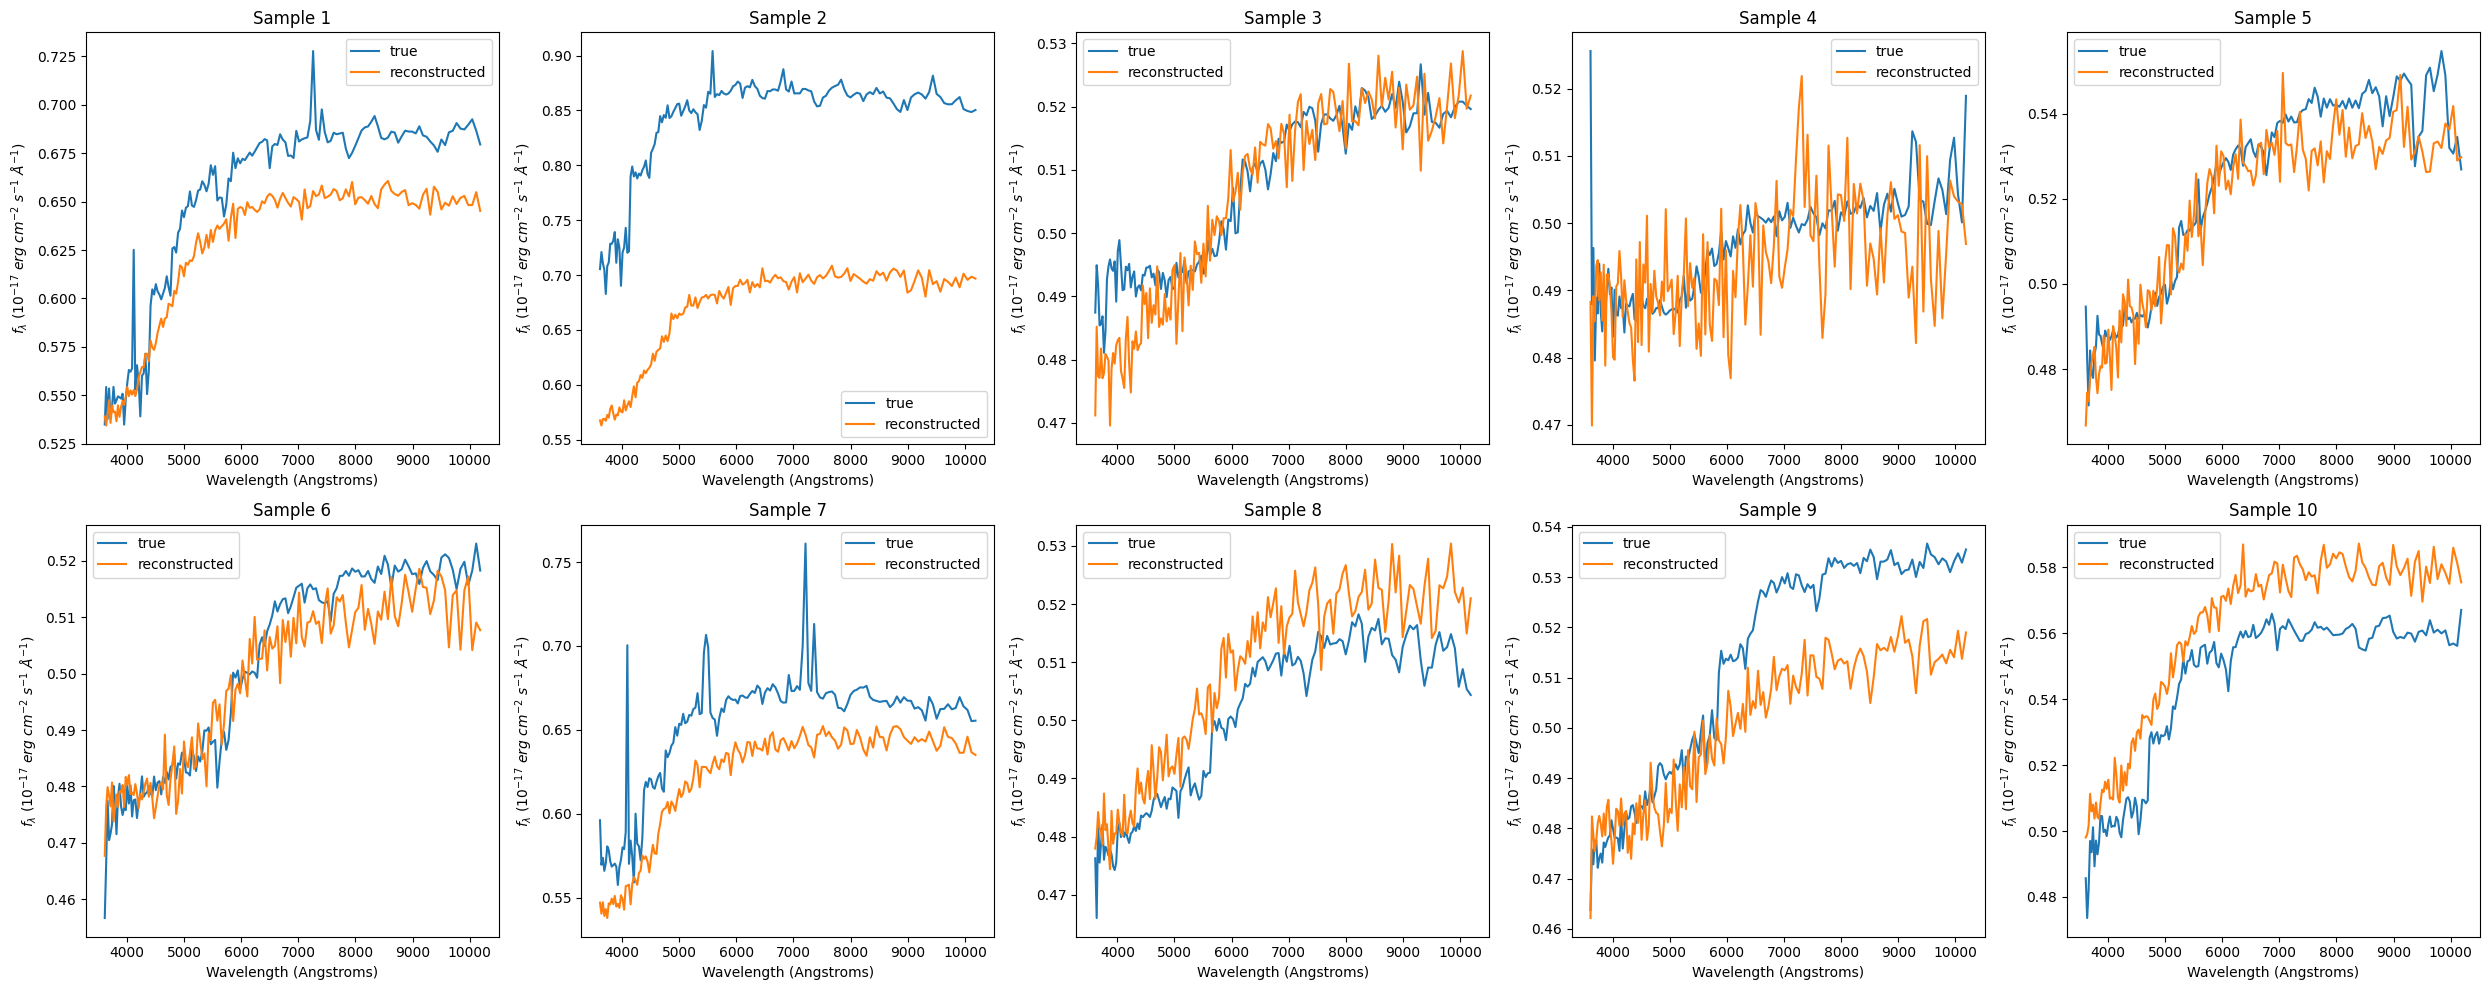

In [ ]:
# Evaluate the trained model
cvae.eval()
with torch.no_grad():
  # Reconstruct test data using the model and test conditional data
  recon_test, mu_test, logvar_test = cvae(test_data.to(device), test_conditional_data_scaled.to(device))

# Select a few samples to visualize
num_samples_to_plot = 10
plt.figure(figsize=(25, 10))
for i in range(num_samples_to_plot):
  plt.subplot(2, 5, i + 1)
  plt.plot(wavelength_low_res, test_data[i].to('cpu').detach().numpy(), label="true")
  plt.plot(wavelength_low_res, recon_test[i].to('cpu').detach().numpy(), label="reconstructed")
  plt.xlabel("Wavelength (Angstroms)")
  plt.ylabel(r'$f_\lambda~(10^{-17}~erg~cm^{-2}~s^{-1}~\AA^{-1})$')
  plt.title(f"Sample {i+1}")
  plt.legend()

plt.tight_layout()
plt.show()

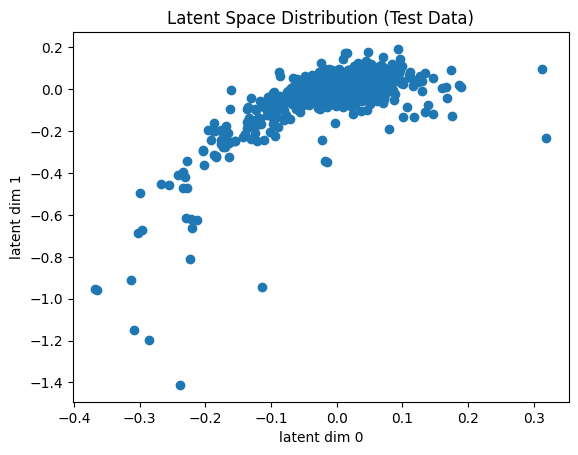

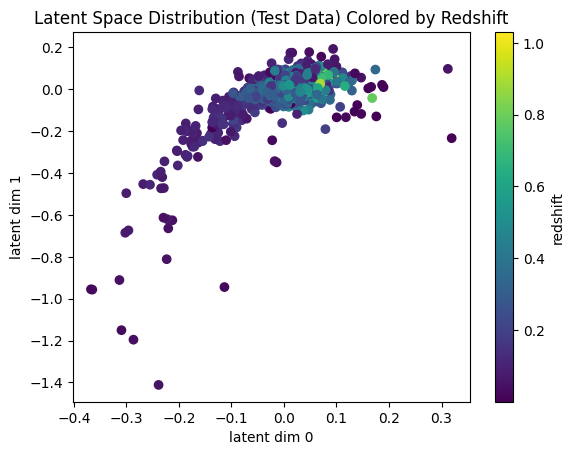

In [ ]:
# Check latent space distribution
cvae.eval()
with torch.no_grad():
  # Use the scaled test conditional data which includes log10 transformations for age and smass
  recon_test, mu_test, logvar_test = cvae(test_data.to(device), test_conditional_data_scaled.to(device))

plt.figure()
plt.scatter(mu_test[:,0].to('cpu').detach().numpy(), mu_test[:,1].to('cpu').detach().numpy())
plt.xlabel("latent dim 0")
plt.ylabel("latent dim 1")
plt.title("Latent Space Distribution (Test Data)")

plt.figure()
# Use original z_test for color mapping as it is the most interpretable
plt.scatter(mu_test[:,0].to('cpu').detach().numpy(), mu_test[:,1].to('cpu').detach().numpy(), c=z_test)
plt.xlabel("latent dim 0")
plt.ylabel("latent dim 1")
plt.colorbar(label="redshift")
plt.title("Latent Space Distribution (Test Data) Colored by Redshift")
plt.show()

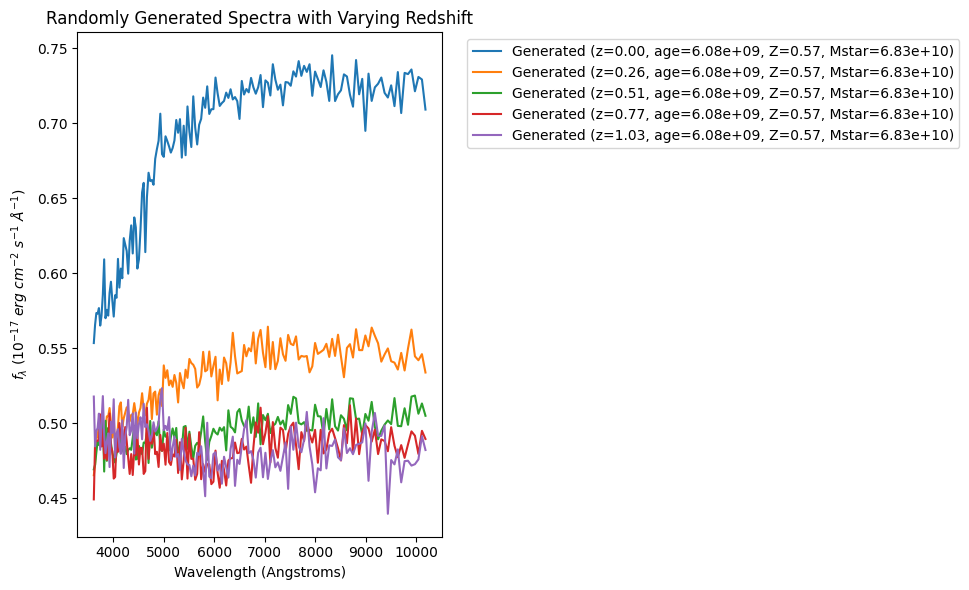

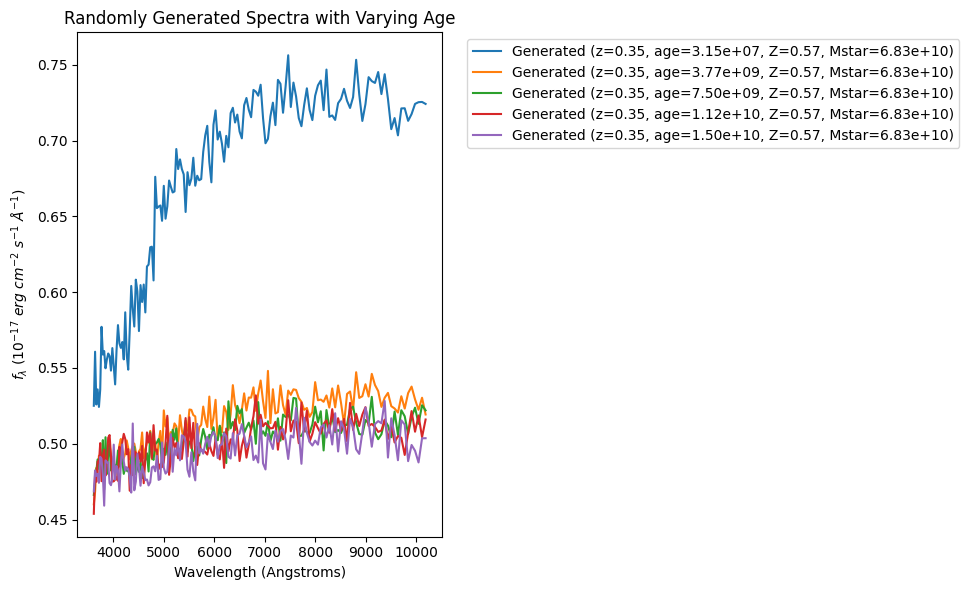

In [ ]:
# Generate new spectra from specific conditional properties and random noise
num_generated_samples = 5
latent_dim = 2 # Ensure latent_dim is defined

# Create specific conditional data for generation (scaled with log10 for age and smass)
# Example: vary redshift while keeping other properties constant (e.g., median values from the test set)
median_z = np.median(z_test)
# Calculate medians for age and smass on the original scale for meaningful labels
median_age_original = np.median(age_test)
median_metallicity_original = np.median(metallicity_test)
median_smass_original = np.median(smass_test)


# Create a range of redshifts to generate spectra for (on the original scale for labels)
z_conditions = np.linspace(np.min(z_test), np.max(z_test), num_generated_samples)

# Create conditional data arrays (on the original scale initially)
generated_conditional_data = np.zeros((num_generated_samples, conditional_dim))
generated_conditional_data[:, 0] = z_conditions
generated_conditional_data[:, 1] = median_age_original
generated_conditional_data[:, 2] = median_metallicity_original
generated_conditional_data[:, 3] = median_smass_original

# Apply log10 transformation to age and smass for scaling, consistent with training data
generated_conditional_data[:, 1] = np.log10(generated_conditional_data[:, 1])
generated_conditional_data[:, 3] = np.log10(generated_conditional_data[:, 3])


# Scale the generated conditional data using the same scaler fitted on the training data
generated_conditional_data_scaled = scaler.transform(generated_conditional_data)
generated_conditional_data_scaled = torch.from_numpy(generated_conditional_data_scaled.astype(np.float32)).to(device)

# Generate random noise in the latent space
noise = torch.randn(num_generated_samples, latent_dim).to(device)

# Generate new spectra using the decoder
cvae.eval()
with torch.no_grad():
  generated_spectra = cvae.generate_sample(noise, generated_conditional_data_scaled)

# Visualize the generated spectra (use original values for labels)
plt.figure(figsize=(10, 6))
for i in range(num_generated_samples):
  plt.plot(wavelength_low_res, generated_spectra[i].to('cpu').detach().numpy(),
           label=f"Generated (z={z_conditions[i]:.2f}, age={median_age_original:.2e}, Z={median_metallicity_original:.2f}, Mstar={median_smass_original:.2e})")

plt.title("Randomly Generated Spectra with Varying Redshift")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel(r'$f_\lambda~(10^{-17}~erg~cm^{-2}~s^{-1}~\AA^{-1})$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# You can repeat the process with different conditional properties if needed
# Example: vary age while keeping other properties constant
# Create a range of ages to generate spectra for (on the original scale for labels)
age_conditions = np.linspace(np.min(age_test), np.max(age_test), num_generated_samples)
generated_conditional_data_age = np.zeros((num_generated_samples, conditional_dim))
generated_conditional_data_age[:, 0] = median_z
generated_conditional_data_age[:, 1] = age_conditions # Original scale for labels
generated_conditional_data_age[:, 2] = median_metallicity_original
generated_conditional_data_age[:, 3] = median_smass_original

# Apply log10 transformation to age and smass for scaling
generated_conditional_data_age[:, 1] = np.log10(generated_conditional_data_age[:, 1])
generated_conditional_data_age[:, 3] = np.log10(generated_conditional_data_age[:, 3])


generated_conditional_data_age_scaled = scaler.transform(generated_conditional_data_age)
generated_conditional_data_age_scaled = torch.from_numpy(generated_conditional_data_age_scaled.astype(np.float32)).to(device)

with torch.no_grad():
    generated_spectra_age = cvae.generate_sample(noise, generated_conditional_data_age_scaled)

plt.figure(figsize=(10, 6))
for i in range(num_generated_samples):
  plt.plot(wavelength_low_res, generated_spectra_age[i].to('cpu').detach().numpy(),
           label=f"Generated (z={median_z:.2f}, age={age_conditions[i]:.2e}, Z={median_metallicity_original:.2f}, Mstar={median_smass_original:.2e})") # Use original age for label

plt.title("Randomly Generated Spectra with Varying Age")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel(r'$f_\lambda~(10^{-17}~erg~cm^{-2}~s^{-1}~\AA^{-1})$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()